In [18]:
import os

import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from torcheval.metrics import MeanSquaredError
from tqdm import tqdm

os.environ['DGLBACKEND'] = 'pytorch'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, 1)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = nn.functional.relu(h)
        h = self.conv2(g, h)
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")
    
    def run_training(self, epochs, dataloader, optimizer, node_features_func):
        self.train()
        for epoch in range(epochs):
            for batched_graph, labels in tqdm(dataloader):
                batched_graph = batched_graph.to(device)
                labels = labels.to(device)
                node_features = node_features_func(batched_graph.ndata).float()
                pred = self(batched_graph, node_features)
                loss = nn.functional.mse_loss(pred, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    @torch.no_grad()
    def run_evaluation(self, dataloader, metric, node_features_func):
        self.eval()
        metric.to(device)
        for batched_graph, labels in dataloader:
            batched_graph = batched_graph.to(device)
            labels = labels.to(device)
            node_features = node_features_func(batched_graph.ndata).float()
            pred = self(batched_graph, node_features)
            metric.update(pred, labels)
        print(metric.compute())

In [20]:
data = dgl.data.QM9Dataset(label_keys=['U'], raw_dir='./data')

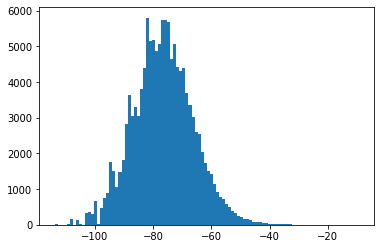

In [21]:
with np.load('./data/qm9_eV.npz') as f:
    labels = f['U']
plt.hist(labels, bins=100)
plt.show()

In [22]:
# train_indices, test_indices = train_test_split(range(len(data)), test_size=0.2, random_state=42)
train_indices, test_indices = train_test_split((range(500)), test_size=0.2, random_state=42)


train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dataloader = GraphDataLoader(data, sampler=train_sampler, batch_size=64, drop_last=False)
test_dataloader = GraphDataLoader(data, sampler=test_sampler, batch_size=64, drop_last=False)

In [23]:
model = GCN(3, 16)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

node_features_func = lambda ndata: ndata["R"]
model.run_training(20, train_dataloader, optimizer, node_features_func)
model.run_evaluation(test_dataloader, MeanSquaredError(), node_features_func)

100%|██████████| 7/7 [00:00<00:00,  8.21it/s]


tensor(278.1709)


In [24]:
model = GCN(4, 16)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

node_features_func = lambda ndata: torch.concatenate([ndata["R"], ndata["Z"].unsqueeze(0).T], dim=1)
model.run_training(20, train_dataloader, optimizer, node_features_func)
model.run_evaluation(test_dataloader, MeanSquaredError(), node_features_func)

100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


tensor(314.7232)
